In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
#!unzip /content/drive/MyDrive/deep-learning-mini-project-spring-24-nyu.zip

In [4]:
#training set
batch1 = unpickle("/kaggle/input/deep-learning-mini-project-spring-24-nyu/cifar-10-python/cifar-10-batches-py/data_batch_1")
batch2 = unpickle("/kaggle/input/deep-learning-mini-project-spring-24-nyu/cifar-10-python/cifar-10-batches-py/data_batch_2")
batch3 = unpickle("/kaggle/input/deep-learning-mini-project-spring-24-nyu/cifar-10-python/cifar-10-batches-py/data_batch_3")
batch4 = unpickle("/kaggle/input/deep-learning-mini-project-spring-24-nyu/cifar-10-python/cifar-10-batches-py/data_batch_4")
batch5 = unpickle("/kaggle/input/deep-learning-mini-project-spring-24-nyu/cifar-10-python/cifar-10-batches-py/data_batch_5")

#test set
test_batch = unpickle("/kaggle/input/deep-learning-mini-project-spring-24-nyu/cifar-10-python/cifar-10-batches-py/test_batch")

In [5]:
print(len(batch1[b'filenames']))
print(len(batch2[b'filenames']))
print(len(batch3[b'filenames']))
print(len(batch4[b'filenames']))
print(len(batch5[b'filenames']))

print(len(test_batch[b'filenames']))

10000
10000
10000
10000
10000
10000


In [6]:
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1


    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()

        DROPOUT = 0.1

        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.dropout = nn.Dropout(DROPOUT)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.dropout = nn.Dropout(DROPOUT)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes),
                nn.Dropout(DROPOUT)
            )
    def forward(self, x):
        out = F.relu(self.dropout(self.bn1(self.conv1(x))))
        out = self.dropout(self.bn2(self.conv2(out)))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 42

        self.conv1 = nn.Conv2d(3, 42, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(42)
        self.layer1 = self._make_layer(block, 42, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 84, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 168, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 336, num_blocks[3], stride=2)
        self.linear = nn.Linear(336*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [7]:
from PIL import Image


class CIFAR10Dataset(Dataset):
    def __init__(self, batch_data, transform=None):
        """
        Args:
            batch_data (list): List of unpickled batch data.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        # Decode byte keys and combine data from all batches
        self.data = np.vstack([batch[b'data'] for batch in batch_data])
        self.data = self.data.reshape(-1, 3, 32, 32).astype('float32')  # reshape to NCHW format
        self.labels = np.hstack([batch[b'labels'] for batch in batch_data])
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]

        # Reshape the image from (3072,) to (3, 32, 32) which is C, H, W
        image = image.reshape(3, 32, 32)

        image = image.transpose(1, 2, 0).astype(np.uint8)

        if self.transform:
            # Convert the NumPy array to PIL Image and apply the transforms
            image = Image.fromarray(image)

            # Apply the transform (including any scaling or normalization)
            image = self.transform(image)

        return image, label

In [8]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation((-7,7)),
    transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [9]:
#Combine batches for training
train_data = [batch1, batch2, batch3, batch4, batch5]

# Create the CIFAR-10 dataset
cifar10_dataset = CIFAR10Dataset(batch_data=train_data, transform=transform)

# Use DataLoader to handle batching
train_loader = DataLoader(cifar10_dataset, batch_size=512, shuffle=True)

# Load test data
test_dataset = CIFAR10Dataset(batch_data=[test_batch], transform=transform)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

In [10]:
train_data[0].keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [11]:
num_classes = 10
model = ResNet18()

In [12]:
!pip install torchsummary

In [13]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', restore_best_weights=False):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.path = path
        self.restore_best_weights = restore_best_weights
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.best_weights = None

    def __call__(self, model, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
                if self.restore_best_weights and self.best_weights is not None:
                    model.load_state_dict(self.best_weights)
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} to {val_loss:.6f}).  Saving model to {self.path}')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss
        if self.restore_best_weights:
            self.best_weights = model.state_dict()



In [14]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score

num_epochs = 300
loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(),lr=0.0005,weight_decay=1e-4)
#optimizer = torch.optim.SGD(model.parameters(),lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20,threshold_mode='rel', cooldown=0, min_lr=0.00001, eps=1e-08, verbose=True)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print(f"Number of GPUs available: {torch.cuda.device_count()}")
    model = nn.DataParallel(model)

model.to(device)
model = model.to(device)


# Function to calculate accuracy
def calculate_accuracy(y_true, y_pred):
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()
    return accuracy_score(y_true, y_pred)

In [15]:
from torchsummary import summary
summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 42, 32, 32]           1,134
       BatchNorm2d-2           [-1, 42, 32, 32]              84
            Conv2d-3           [-1, 42, 32, 32]          15,876
       BatchNorm2d-4           [-1, 42, 32, 32]              84
           Dropout-5           [-1, 42, 32, 32]               0
            Conv2d-6           [-1, 42, 32, 32]          15,876
       BatchNorm2d-7           [-1, 42, 32, 32]              84
           Dropout-8           [-1, 42, 32, 32]               0
        BasicBlock-9           [-1, 42, 32, 32]               0
           Conv2d-10           [-1, 42, 32, 32]          15,876
      BatchNorm2d-11           [-1, 42, 32, 32]              84
          Dropout-12           [-1, 42, 32, 32]               0
           Conv2d-13           [-1, 42, 32, 32]          15,876
      BatchNorm2d-14           [-1, 42,

In [16]:
'''
##1.without early stoping

from tqdm import tqdm

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Training]')
    for data, labels in train_bar:
        data, labels = data.to(device), labels.to(device)

        # Forward pass
        outputs = model(data)
        loss = loss_function(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update the progress bar
        train_bar.set_postfix(loss=loss.item())

    # Validate the model
    model.eval()
    validation_loss = 0
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            loss = loss_function(outputs, labels)
            validation_loss += loss.item() * data.size(0)
    validation_loss /= len(test_loader.dataset)

    # Step the scheduler
    scheduler.step(validation_loss)

    # Test the model
    test_bar = tqdm(test_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Testing]')
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        test_bar.set_postfix(accuracy=f'{accuracy:.2f}%')

    print(f'Accuracy of the model on the validation set: {accuracy:.2f}%')

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')
'''

"\n##1.without early stoping\n\nfrom tqdm import tqdm\n\nfor epoch in range(num_epochs):\n    model.train()  # Set the model to training mode\n    train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Training]')\n    for data, labels in train_bar:\n        data, labels = data.to(device), labels.to(device)\n\n        # Forward pass\n        outputs = model(data)\n        loss = loss_function(outputs, labels)\n\n        # Backward and optimize\n        optimizer.zero_grad()\n        loss.backward()\n        optimizer.step()\n\n        # Update the progress bar\n        train_bar.set_postfix(loss=loss.item())\n\n    # Validate the model\n    model.eval()\n    validation_loss = 0\n    with torch.no_grad():\n        for data, labels in test_loader:\n            data, labels = data.to(device), labels.to(device)\n            outputs = model(data)\n            loss = loss_function(outputs, labels)\n            validation_loss += loss.item() * data.size(0)\n    validation_loss /=

In [17]:
#2. with early stopping
from tqdm import tqdm


# Initialize metrics storage
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Initialize the early stopping object
early_stopping = EarlyStopping( patience=40, restore_best_weights=True, verbose=1)

for epoch in range(num_epochs):
    model.train()
    
    train_loss = 0.0
    correct = 0
    total = 0
    
    train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Training]')
    for data, labels in train_bar:
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = loss_function(outputs, labels)
        train_loss += loss.item() * data.size(0)
        loss.backward()
        
        
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        train_bar.set_postfix(loss=loss.item())
        
    train_losses.append(train_loss / len(train_loader.dataset))
    train_accuracies.append(100 * correct / total)

    model.eval()
    validation_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        val_bar = tqdm(test_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Validation]')
        for data, labels in val_bar:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            loss = loss_function(outputs, labels)
            validation_loss += loss.item() * data.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        accuracy = 100 * correct / total
    
        val_losses.append(validation_loss / len(test_loader.dataset))
        val_accuracies.append(accuracy)
        val_loss = validation_loss / len(test_loader.dataset)
        val_bar.set_postfix(loss=validation_loss/len(test_loader.dataset), accuracy=f'{accuracy:.2f}%')
    
    
    validation_loss /= len(test_loader.dataset)
    print(f'Epoch {epoch+1}: Validation Loss: {validation_loss:.4f}, Accuracy: {accuracy:.2f}%')
   
    # Step the scheduler and apply early stopping
    scheduler.step(validation_loss)
    early_stopping(model,validation_loss)
    
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

# Load the last best model
model.load_state_dict(torch.load('checkpoint.pt'))

Epoch 1/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Epoch 1: Validation Loss: 1.5833, Accuracy: 43.94%
Validation loss decreased (inf to 1.583274).  Saving model to checkpoint.pt


Epoch 2/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.91it/s]


Epoch 2: Validation Loss: 1.2547, Accuracy: 55.43%
Validation loss decreased (1.583274 to 1.254721).  Saving model to checkpoint.pt


Epoch 3/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.91it/s]


Epoch 3: Validation Loss: 1.1893, Accuracy: 58.36%
Validation loss decreased (1.254721 to 1.189272).  Saving model to checkpoint.pt


Epoch 4/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.91it/s]


Epoch 4: Validation Loss: 1.0186, Accuracy: 64.31%
Validation loss decreased (1.189272 to 1.018633).  Saving model to checkpoint.pt


Epoch 5/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.92it/s]


Epoch 5: Validation Loss: 0.8491, Accuracy: 70.66%
Validation loss decreased (1.018633 to 0.849134).  Saving model to checkpoint.pt


Epoch 6/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.92it/s]


Epoch 6: Validation Loss: 0.8779, Accuracy: 69.63%
EarlyStopping counter: 1 out of 40


Epoch 7/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Epoch 7: Validation Loss: 0.7795, Accuracy: 72.83%
Validation loss decreased (0.849134 to 0.779514).  Saving model to checkpoint.pt


Epoch 8/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.92it/s]


Epoch 8: Validation Loss: 0.7507, Accuracy: 74.03%
Validation loss decreased (0.779514 to 0.750678).  Saving model to checkpoint.pt


Epoch 9/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.94it/s]


Epoch 9: Validation Loss: 0.7026, Accuracy: 75.91%
Validation loss decreased (0.750678 to 0.702611).  Saving model to checkpoint.pt


Epoch 10/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Epoch 10: Validation Loss: 0.6843, Accuracy: 75.84%
Validation loss decreased (0.702611 to 0.684299).  Saving model to checkpoint.pt


Epoch 11/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.94it/s]


Epoch 11: Validation Loss: 0.6478, Accuracy: 77.89%
Validation loss decreased (0.684299 to 0.647832).  Saving model to checkpoint.pt


Epoch 12/300 [Validation]: 100%|██████████| 20/20 [00:11<00:00,  1.80it/s]


Epoch 12: Validation Loss: 0.6102, Accuracy: 79.40%
Validation loss decreased (0.647832 to 0.610181).  Saving model to checkpoint.pt


Epoch 13/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Epoch 13: Validation Loss: 0.6442, Accuracy: 78.46%
EarlyStopping counter: 1 out of 40


Epoch 14/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Epoch 14: Validation Loss: 0.6049, Accuracy: 78.89%
Validation loss decreased (0.610181 to 0.604868).  Saving model to checkpoint.pt


Epoch 15/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.93it/s]


Epoch 15: Validation Loss: 0.6500, Accuracy: 77.77%
EarlyStopping counter: 1 out of 40


Epoch 16/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Epoch 16: Validation Loss: 0.5938, Accuracy: 79.83%
Validation loss decreased (0.604868 to 0.593824).  Saving model to checkpoint.pt


Epoch 17/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Epoch 17: Validation Loss: 0.5315, Accuracy: 82.02%
Validation loss decreased (0.593824 to 0.531524).  Saving model to checkpoint.pt


Epoch 18/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.92it/s]


Epoch 18: Validation Loss: 0.5403, Accuracy: 81.07%
EarlyStopping counter: 1 out of 40


Epoch 19/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.93it/s]


Epoch 19: Validation Loss: 0.5944, Accuracy: 80.48%
EarlyStopping counter: 2 out of 40


Epoch 20/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.91it/s]


Epoch 20: Validation Loss: 0.5898, Accuracy: 79.99%
EarlyStopping counter: 3 out of 40


Epoch 21/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.91it/s]


Epoch 21: Validation Loss: 0.6096, Accuracy: 79.32%
EarlyStopping counter: 4 out of 40


Epoch 22/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.92it/s]


Epoch 22: Validation Loss: 0.5898, Accuracy: 80.41%
EarlyStopping counter: 5 out of 40


Epoch 23/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.91it/s]


Epoch 23: Validation Loss: 0.5340, Accuracy: 82.40%
EarlyStopping counter: 6 out of 40


Epoch 24/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.92it/s]


Epoch 24: Validation Loss: 0.5088, Accuracy: 82.79%
Validation loss decreased (0.531524 to 0.508796).  Saving model to checkpoint.pt


Epoch 25/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Epoch 25: Validation Loss: 0.5141, Accuracy: 83.00%
EarlyStopping counter: 1 out of 40


Epoch 26/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.91it/s]


Epoch 26: Validation Loss: 0.4787, Accuracy: 83.89%
Validation loss decreased (0.508796 to 0.478722).  Saving model to checkpoint.pt


Epoch 27/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.93it/s]


Epoch 27: Validation Loss: 0.5112, Accuracy: 82.18%
EarlyStopping counter: 1 out of 40


Epoch 28/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.91it/s]


Epoch 28: Validation Loss: 0.4644, Accuracy: 83.78%
Validation loss decreased (0.478722 to 0.464428).  Saving model to checkpoint.pt


Epoch 29/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.92it/s]


Epoch 29: Validation Loss: 0.4674, Accuracy: 84.25%
EarlyStopping counter: 1 out of 40


Epoch 30/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Epoch 30: Validation Loss: 0.4768, Accuracy: 84.03%
EarlyStopping counter: 2 out of 40


Epoch 31/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.93it/s]


Epoch 31: Validation Loss: 0.4618, Accuracy: 84.85%
Validation loss decreased (0.464428 to 0.461809).  Saving model to checkpoint.pt


Epoch 32/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.91it/s]


Epoch 32: Validation Loss: 0.5319, Accuracy: 82.41%
EarlyStopping counter: 1 out of 40


Epoch 33/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.93it/s]


Epoch 33: Validation Loss: 0.4692, Accuracy: 84.32%
EarlyStopping counter: 2 out of 40


Epoch 34/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Epoch 34: Validation Loss: 0.4354, Accuracy: 85.05%
Validation loss decreased (0.461809 to 0.435378).  Saving model to checkpoint.pt


Epoch 35/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Epoch 35: Validation Loss: 0.4324, Accuracy: 85.30%
Validation loss decreased (0.435378 to 0.432423).  Saving model to checkpoint.pt


Epoch 36/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Epoch 36: Validation Loss: 0.4321, Accuracy: 85.50%
Validation loss decreased (0.432423 to 0.432055).  Saving model to checkpoint.pt


Epoch 37/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.93it/s]


Epoch 37: Validation Loss: 0.4191, Accuracy: 85.72%
Validation loss decreased (0.432055 to 0.419095).  Saving model to checkpoint.pt


Epoch 38/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Epoch 38: Validation Loss: 0.4335, Accuracy: 85.32%
EarlyStopping counter: 1 out of 40


Epoch 39/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Epoch 39: Validation Loss: 0.4507, Accuracy: 84.69%
EarlyStopping counter: 2 out of 40


Epoch 40/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.91it/s]


Epoch 40: Validation Loss: 0.4298, Accuracy: 85.47%
EarlyStopping counter: 3 out of 40


Epoch 41/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.93it/s]


Epoch 41: Validation Loss: 0.4466, Accuracy: 85.20%
EarlyStopping counter: 4 out of 40


Epoch 42/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


Epoch 42: Validation Loss: 0.4283, Accuracy: 85.38%
EarlyStopping counter: 5 out of 40


Epoch 43/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.92it/s]


Epoch 43: Validation Loss: 0.4165, Accuracy: 85.93%
Validation loss decreased (0.419095 to 0.416490).  Saving model to checkpoint.pt


Epoch 44/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.88it/s]


Epoch 44: Validation Loss: 0.4803, Accuracy: 84.26%
EarlyStopping counter: 1 out of 40


Epoch 45/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.92it/s]


Epoch 45: Validation Loss: 0.4517, Accuracy: 84.93%
EarlyStopping counter: 2 out of 40


Epoch 46/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Epoch 46: Validation Loss: 0.4547, Accuracy: 85.00%
EarlyStopping counter: 3 out of 40


Epoch 47/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.91it/s]


Epoch 47: Validation Loss: 0.3919, Accuracy: 86.83%
Validation loss decreased (0.416490 to 0.391920).  Saving model to checkpoint.pt


Epoch 48/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Epoch 48: Validation Loss: 0.4173, Accuracy: 86.00%
EarlyStopping counter: 1 out of 40


Epoch 49/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.93it/s]


Epoch 49: Validation Loss: 0.4593, Accuracy: 84.55%
EarlyStopping counter: 2 out of 40


Epoch 50/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.92it/s]


Epoch 50: Validation Loss: 0.3937, Accuracy: 86.61%
EarlyStopping counter: 3 out of 40


Epoch 51/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.92it/s]


Epoch 51: Validation Loss: 0.4124, Accuracy: 86.51%
EarlyStopping counter: 4 out of 40


Epoch 52/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Epoch 52: Validation Loss: 0.4447, Accuracy: 85.30%
EarlyStopping counter: 5 out of 40


Epoch 53/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.88it/s]


Epoch 53: Validation Loss: 0.4147, Accuracy: 86.27%
EarlyStopping counter: 6 out of 40


Epoch 54/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.93it/s]


Epoch 54: Validation Loss: 0.3969, Accuracy: 86.88%
EarlyStopping counter: 7 out of 40


Epoch 55/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.92it/s]


Epoch 55: Validation Loss: 0.4092, Accuracy: 86.68%
EarlyStopping counter: 8 out of 40


Epoch 56/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.93it/s]


Epoch 56: Validation Loss: 0.3906, Accuracy: 87.20%
Validation loss decreased (0.391920 to 0.390580).  Saving model to checkpoint.pt


Epoch 57/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.91it/s]


Epoch 57: Validation Loss: 0.4317, Accuracy: 86.08%
EarlyStopping counter: 1 out of 40


Epoch 58/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Epoch 58: Validation Loss: 0.4216, Accuracy: 86.26%
EarlyStopping counter: 2 out of 40


Epoch 59/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.93it/s]


Epoch 59: Validation Loss: 0.4179, Accuracy: 86.63%
EarlyStopping counter: 3 out of 40


Epoch 60/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.91it/s]


Epoch 60: Validation Loss: 0.3883, Accuracy: 87.21%
Validation loss decreased (0.390580 to 0.388346).  Saving model to checkpoint.pt


Epoch 61/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.93it/s]


Epoch 61: Validation Loss: 0.4261, Accuracy: 86.48%
EarlyStopping counter: 1 out of 40


Epoch 62/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.88it/s]


Epoch 62: Validation Loss: 0.4153, Accuracy: 86.02%
EarlyStopping counter: 2 out of 40


Epoch 63/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.93it/s]


Epoch 63: Validation Loss: 0.3821, Accuracy: 87.73%
Validation loss decreased (0.388346 to 0.382110).  Saving model to checkpoint.pt


Epoch 64/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Epoch 64: Validation Loss: 0.3818, Accuracy: 87.52%
Validation loss decreased (0.382110 to 0.381770).  Saving model to checkpoint.pt


Epoch 65/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.93it/s]


Epoch 65: Validation Loss: 0.4065, Accuracy: 86.78%
EarlyStopping counter: 1 out of 40


Epoch 66/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.91it/s]


Epoch 66: Validation Loss: 0.3801, Accuracy: 87.68%
Validation loss decreased (0.381770 to 0.380124).  Saving model to checkpoint.pt


Epoch 67/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.92it/s]


Epoch 67: Validation Loss: 0.3734, Accuracy: 87.64%
Validation loss decreased (0.380124 to 0.373392).  Saving model to checkpoint.pt


Epoch 68/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.92it/s]


Epoch 68: Validation Loss: 0.3771, Accuracy: 87.62%
EarlyStopping counter: 1 out of 40


Epoch 69/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


Epoch 69: Validation Loss: 0.3869, Accuracy: 88.01%
EarlyStopping counter: 2 out of 40


Epoch 70/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Epoch 70: Validation Loss: 0.4047, Accuracy: 87.08%
EarlyStopping counter: 3 out of 40


Epoch 71/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.91it/s]


Epoch 71: Validation Loss: 0.3971, Accuracy: 87.23%
EarlyStopping counter: 4 out of 40


Epoch 72/300 [Validation]: 100%|██████████| 20/20 [00:11<00:00,  1.79it/s]


Epoch 72: Validation Loss: 0.3883, Accuracy: 87.44%
EarlyStopping counter: 5 out of 40


Epoch 73/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.84it/s]


Epoch 73: Validation Loss: 0.3978, Accuracy: 87.15%
EarlyStopping counter: 6 out of 40


Epoch 74/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Epoch 74: Validation Loss: 0.3973, Accuracy: 87.29%
EarlyStopping counter: 7 out of 40


Epoch 75/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.88it/s]


Epoch 75: Validation Loss: 0.3598, Accuracy: 88.60%
Validation loss decreased (0.373392 to 0.359750).  Saving model to checkpoint.pt


Epoch 76/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Epoch 76: Validation Loss: 0.3957, Accuracy: 87.29%
EarlyStopping counter: 1 out of 40


Epoch 77/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.91it/s]


Epoch 77: Validation Loss: 0.3985, Accuracy: 87.18%
EarlyStopping counter: 2 out of 40


Epoch 78/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.88it/s]


Epoch 78: Validation Loss: 0.4163, Accuracy: 86.51%
EarlyStopping counter: 3 out of 40


Epoch 79/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.91it/s]


Epoch 79: Validation Loss: 0.3986, Accuracy: 87.44%
EarlyStopping counter: 4 out of 40


Epoch 80/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Epoch 80: Validation Loss: 0.3565, Accuracy: 88.43%
Validation loss decreased (0.359750 to 0.356458).  Saving model to checkpoint.pt


Epoch 81/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Epoch 81: Validation Loss: 0.3787, Accuracy: 88.07%
EarlyStopping counter: 1 out of 40


Epoch 82/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.92it/s]


Epoch 82: Validation Loss: 0.3588, Accuracy: 88.68%
EarlyStopping counter: 2 out of 40


Epoch 83/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Epoch 83: Validation Loss: 0.3723, Accuracy: 87.78%
EarlyStopping counter: 3 out of 40


Epoch 84/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.93it/s]


Epoch 84: Validation Loss: 0.3900, Accuracy: 87.72%
EarlyStopping counter: 4 out of 40


Epoch 85/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Epoch 85: Validation Loss: 0.4314, Accuracy: 86.40%
EarlyStopping counter: 5 out of 40


Epoch 86/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.91it/s]


Epoch 86: Validation Loss: 0.3965, Accuracy: 87.58%
EarlyStopping counter: 6 out of 40


Epoch 87/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.92it/s]


Epoch 87: Validation Loss: 0.3747, Accuracy: 88.03%
EarlyStopping counter: 7 out of 40


Epoch 88/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.91it/s]


Epoch 88: Validation Loss: 0.3635, Accuracy: 88.65%
EarlyStopping counter: 8 out of 40


Epoch 89/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.91it/s]


Epoch 89: Validation Loss: 0.3611, Accuracy: 88.46%
EarlyStopping counter: 9 out of 40


Epoch 90/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


Epoch 90: Validation Loss: 0.3534, Accuracy: 88.48%
Validation loss decreased (0.356458 to 0.353352).  Saving model to checkpoint.pt


Epoch 91/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.91it/s]


Epoch 91: Validation Loss: 0.3598, Accuracy: 88.36%
EarlyStopping counter: 1 out of 40


Epoch 92/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.91it/s]


Epoch 92: Validation Loss: 0.3820, Accuracy: 88.04%
EarlyStopping counter: 2 out of 40


Epoch 93/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.88it/s]


Epoch 93: Validation Loss: 0.3760, Accuracy: 88.16%
EarlyStopping counter: 3 out of 40


Epoch 94/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.88it/s]


Epoch 94: Validation Loss: 0.3591, Accuracy: 88.76%
EarlyStopping counter: 4 out of 40


Epoch 95/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


Epoch 95: Validation Loss: 0.3864, Accuracy: 87.69%
EarlyStopping counter: 5 out of 40


Epoch 96/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.91it/s]


Epoch 96: Validation Loss: 0.3761, Accuracy: 88.16%
EarlyStopping counter: 6 out of 40


Epoch 97/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Epoch 97: Validation Loss: 0.3765, Accuracy: 88.02%
EarlyStopping counter: 7 out of 40


Epoch 98/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.92it/s]


Epoch 98: Validation Loss: 0.3785, Accuracy: 88.29%
EarlyStopping counter: 8 out of 40


Epoch 99/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


Epoch 99: Validation Loss: 0.3873, Accuracy: 88.08%
EarlyStopping counter: 9 out of 40


Epoch 100/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Epoch 100: Validation Loss: 0.3680, Accuracy: 88.59%
EarlyStopping counter: 10 out of 40


Epoch 101/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Epoch 101: Validation Loss: 0.3479, Accuracy: 89.13%
Validation loss decreased (0.353352 to 0.347885).  Saving model to checkpoint.pt


Epoch 102/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Epoch 102: Validation Loss: 0.3536, Accuracy: 88.70%
EarlyStopping counter: 1 out of 40


Epoch 103/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Epoch 103: Validation Loss: 0.3486, Accuracy: 88.99%
EarlyStopping counter: 2 out of 40


Epoch 104/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


Epoch 104: Validation Loss: 0.3588, Accuracy: 88.27%
EarlyStopping counter: 3 out of 40


Epoch 105/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.88it/s]


Epoch 105: Validation Loss: 0.3782, Accuracy: 88.23%
EarlyStopping counter: 4 out of 40


Epoch 106/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


Epoch 106: Validation Loss: 0.3477, Accuracy: 89.25%
Validation loss decreased (0.347885 to 0.347659).  Saving model to checkpoint.pt


Epoch 107/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Epoch 107: Validation Loss: 0.3740, Accuracy: 88.30%
EarlyStopping counter: 1 out of 40


Epoch 108/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Epoch 108: Validation Loss: 0.3734, Accuracy: 88.54%
EarlyStopping counter: 2 out of 40


Epoch 109/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Epoch 109: Validation Loss: 0.3680, Accuracy: 88.63%
EarlyStopping counter: 3 out of 40


Epoch 110/300 [Validation]: 100%|██████████| 20/20 [00:11<00:00,  1.82it/s]


Epoch 110: Validation Loss: 0.3965, Accuracy: 87.90%
EarlyStopping counter: 4 out of 40


Epoch 111/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Epoch 111: Validation Loss: 0.3571, Accuracy: 88.65%
EarlyStopping counter: 5 out of 40


Epoch 112/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Epoch 112: Validation Loss: 0.3247, Accuracy: 89.63%
Validation loss decreased (0.347659 to 0.324703).  Saving model to checkpoint.pt


Epoch 113/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Epoch 113: Validation Loss: 0.3743, Accuracy: 88.50%
EarlyStopping counter: 1 out of 40


Epoch 114/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.88it/s]


Epoch 114: Validation Loss: 0.3719, Accuracy: 88.38%
EarlyStopping counter: 2 out of 40


Epoch 115/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.88it/s]


Epoch 115: Validation Loss: 0.3693, Accuracy: 88.90%
EarlyStopping counter: 3 out of 40


Epoch 116/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Epoch 116: Validation Loss: 0.3606, Accuracy: 88.87%
EarlyStopping counter: 4 out of 40


Epoch 117/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Epoch 117: Validation Loss: 0.3673, Accuracy: 88.61%
EarlyStopping counter: 5 out of 40


Epoch 118/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.82it/s]


Epoch 118: Validation Loss: 0.4177, Accuracy: 87.49%
EarlyStopping counter: 6 out of 40


Epoch 119/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Epoch 119: Validation Loss: 0.3972, Accuracy: 87.34%
EarlyStopping counter: 7 out of 40


Epoch 120/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.88it/s]


Epoch 120: Validation Loss: 0.3603, Accuracy: 89.05%
EarlyStopping counter: 8 out of 40


Epoch 121/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


Epoch 121: Validation Loss: 0.4127, Accuracy: 87.58%
EarlyStopping counter: 9 out of 40


Epoch 122/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Epoch 122: Validation Loss: 0.3738, Accuracy: 88.51%
EarlyStopping counter: 10 out of 40


Epoch 123/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Epoch 123: Validation Loss: 0.3486, Accuracy: 89.25%
EarlyStopping counter: 11 out of 40


Epoch 124/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


Epoch 124: Validation Loss: 0.3427, Accuracy: 89.33%
EarlyStopping counter: 12 out of 40


Epoch 125/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Epoch 125: Validation Loss: 0.3429, Accuracy: 89.61%
EarlyStopping counter: 13 out of 40


Epoch 126/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Epoch 126: Validation Loss: 0.3783, Accuracy: 88.57%
EarlyStopping counter: 14 out of 40


Epoch 127/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.84it/s]


Epoch 127: Validation Loss: 0.3744, Accuracy: 88.63%
EarlyStopping counter: 15 out of 40


Epoch 128/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Epoch 128: Validation Loss: 0.3731, Accuracy: 88.68%
EarlyStopping counter: 16 out of 40


Epoch 129/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Epoch 129: Validation Loss: 0.3859, Accuracy: 88.29%
EarlyStopping counter: 17 out of 40


Epoch 130/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.84it/s]


Epoch 130: Validation Loss: 0.3876, Accuracy: 88.25%
EarlyStopping counter: 18 out of 40


Epoch 131/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Epoch 131: Validation Loss: 0.3654, Accuracy: 88.49%
EarlyStopping counter: 19 out of 40


Epoch 132/300 [Validation]: 100%|██████████| 20/20 [00:11<00:00,  1.81it/s]


Epoch 132: Validation Loss: 0.3792, Accuracy: 88.76%
EarlyStopping counter: 20 out of 40


Epoch 133/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Epoch 133: Validation Loss: 0.3578, Accuracy: 89.12%
Epoch 00133: reducing learning rate of group 0 to 2.5000e-04.
EarlyStopping counter: 21 out of 40


Epoch 134/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.84it/s]


Epoch 134: Validation Loss: 0.3243, Accuracy: 90.17%
Validation loss decreased (0.324703 to 0.324302).  Saving model to checkpoint.pt


Epoch 135/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Epoch 135: Validation Loss: 0.3331, Accuracy: 90.20%
EarlyStopping counter: 1 out of 40


Epoch 136/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Epoch 136: Validation Loss: 0.3408, Accuracy: 90.02%
EarlyStopping counter: 2 out of 40


Epoch 137/300 [Validation]: 100%|██████████| 20/20 [00:11<00:00,  1.80it/s]


Epoch 137: Validation Loss: 0.3182, Accuracy: 90.20%
Validation loss decreased (0.324302 to 0.318157).  Saving model to checkpoint.pt


Epoch 138/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.82it/s]


Epoch 138: Validation Loss: 0.3234, Accuracy: 90.57%
EarlyStopping counter: 1 out of 40


Epoch 139/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.82it/s]


Epoch 139: Validation Loss: 0.3468, Accuracy: 89.89%
EarlyStopping counter: 2 out of 40


Epoch 140/300 [Validation]: 100%|██████████| 20/20 [00:11<00:00,  1.81it/s]


Epoch 140: Validation Loss: 0.3256, Accuracy: 90.36%
EarlyStopping counter: 3 out of 40


Epoch 141/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Epoch 141: Validation Loss: 0.3561, Accuracy: 89.48%
EarlyStopping counter: 4 out of 40


Epoch 142/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Epoch 142: Validation Loss: 0.3416, Accuracy: 90.18%
EarlyStopping counter: 5 out of 40


Epoch 143/300 [Validation]: 100%|██████████| 20/20 [00:11<00:00,  1.80it/s]


Epoch 143: Validation Loss: 0.3434, Accuracy: 90.02%
EarlyStopping counter: 6 out of 40


Epoch 144/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.84it/s]


Epoch 144: Validation Loss: 0.3488, Accuracy: 90.09%
EarlyStopping counter: 7 out of 40


Epoch 145/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.82it/s]


Epoch 145: Validation Loss: 0.3615, Accuracy: 89.67%
EarlyStopping counter: 8 out of 40


Epoch 146/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Epoch 146: Validation Loss: 0.3667, Accuracy: 89.58%
EarlyStopping counter: 9 out of 40


Epoch 147/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.84it/s]


Epoch 147: Validation Loss: 0.3579, Accuracy: 89.48%
EarlyStopping counter: 10 out of 40


Epoch 148/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Epoch 148: Validation Loss: 0.3473, Accuracy: 90.00%
EarlyStopping counter: 11 out of 40


Epoch 149/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Epoch 149: Validation Loss: 0.3405, Accuracy: 90.47%
EarlyStopping counter: 12 out of 40


Epoch 150/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


Epoch 150: Validation Loss: 0.3409, Accuracy: 90.24%
EarlyStopping counter: 13 out of 40


Epoch 151/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Epoch 151: Validation Loss: 0.3650, Accuracy: 89.79%
EarlyStopping counter: 14 out of 40


Epoch 152/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


Epoch 152: Validation Loss: 0.3539, Accuracy: 89.78%
EarlyStopping counter: 15 out of 40


Epoch 153/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.84it/s]


Epoch 153: Validation Loss: 0.3462, Accuracy: 90.29%
EarlyStopping counter: 16 out of 40


Epoch 154/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


Epoch 154: Validation Loss: 0.3609, Accuracy: 89.64%
EarlyStopping counter: 17 out of 40


Epoch 155/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Epoch 155: Validation Loss: 0.3373, Accuracy: 90.01%
EarlyStopping counter: 18 out of 40


Epoch 156/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Epoch 156: Validation Loss: 0.3585, Accuracy: 90.23%
EarlyStopping counter: 19 out of 40


Epoch 157/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.88it/s]


Epoch 157: Validation Loss: 0.3531, Accuracy: 90.12%
EarlyStopping counter: 20 out of 40


Epoch 158/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.84it/s]


Epoch 158: Validation Loss: 0.3495, Accuracy: 89.99%
Epoch 00158: reducing learning rate of group 0 to 1.2500e-04.
EarlyStopping counter: 21 out of 40


Epoch 159/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Epoch 159: Validation Loss: 0.3346, Accuracy: 90.70%
EarlyStopping counter: 22 out of 40


Epoch 160/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


Epoch 160: Validation Loss: 0.3305, Accuracy: 91.14%
EarlyStopping counter: 23 out of 40


Epoch 161/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Epoch 161: Validation Loss: 0.3360, Accuracy: 90.74%
EarlyStopping counter: 24 out of 40


Epoch 162/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Epoch 162: Validation Loss: 0.3401, Accuracy: 90.96%
EarlyStopping counter: 25 out of 40


Epoch 163/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.82it/s]


Epoch 163: Validation Loss: 0.3324, Accuracy: 90.94%
EarlyStopping counter: 26 out of 40


Epoch 164/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


Epoch 164: Validation Loss: 0.3492, Accuracy: 90.74%
EarlyStopping counter: 27 out of 40


Epoch 165/300 [Validation]: 100%|██████████| 20/20 [00:11<00:00,  1.79it/s]


Epoch 165: Validation Loss: 0.3478, Accuracy: 90.31%
EarlyStopping counter: 28 out of 40


Epoch 166/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Epoch 166: Validation Loss: 0.3490, Accuracy: 90.36%
EarlyStopping counter: 29 out of 40


Epoch 167/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.84it/s]


Epoch 167: Validation Loss: 0.3457, Accuracy: 90.64%
EarlyStopping counter: 30 out of 40


Epoch 168/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


Epoch 168: Validation Loss: 0.3479, Accuracy: 90.59%
EarlyStopping counter: 31 out of 40


Epoch 169/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


Epoch 169: Validation Loss: 0.3453, Accuracy: 90.90%
EarlyStopping counter: 32 out of 40


Epoch 170/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


Epoch 170: Validation Loss: 0.3359, Accuracy: 90.76%
EarlyStopping counter: 33 out of 40


Epoch 171/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.82it/s]


Epoch 171: Validation Loss: 0.3468, Accuracy: 90.72%
EarlyStopping counter: 34 out of 40


Epoch 172/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.88it/s]


Epoch 172: Validation Loss: 0.3400, Accuracy: 90.69%
EarlyStopping counter: 35 out of 40


Epoch 173/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Epoch 173: Validation Loss: 0.3470, Accuracy: 90.57%
EarlyStopping counter: 36 out of 40


Epoch 174/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


Epoch 174: Validation Loss: 0.3505, Accuracy: 90.43%
EarlyStopping counter: 37 out of 40


Epoch 175/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Epoch 175: Validation Loss: 0.3516, Accuracy: 90.85%
EarlyStopping counter: 38 out of 40


Epoch 176/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Epoch 176: Validation Loss: 0.3404, Accuracy: 90.74%
EarlyStopping counter: 39 out of 40


Epoch 177/300 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.83it/s]

Epoch 177: Validation Loss: 0.3400, Accuracy: 90.90%
EarlyStopping counter: 40 out of 40
Early stopping triggered


<All keys matched successfully>

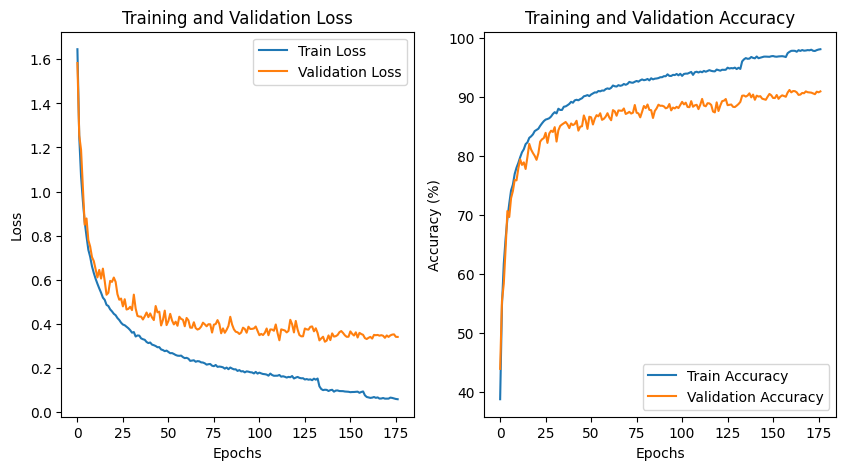

In [18]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

In [19]:
import pickle
def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        batch = pickle.load(fo, encoding='bytes')
    return batch

# Load the batch
cifar10_batch = load_cifar_batch('/kaggle/input/deep-learning-mini-project-spring-24-nyu/cifar_test_nolabels.pkl')

# Extract images
images = cifar10_batch[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

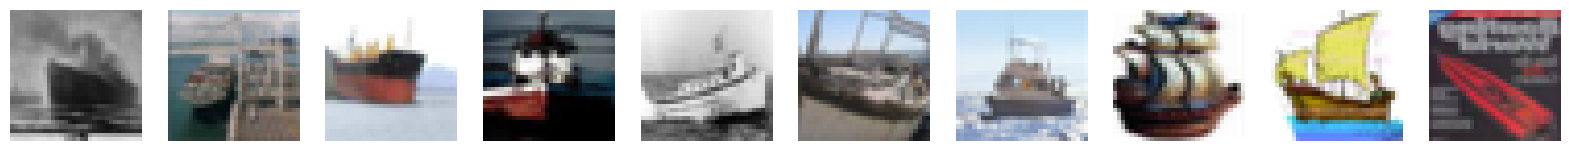

In [20]:
import matplotlib.pyplot as plt
images = cifar10_batch[b'data']
# Reshape to (number of images, width, height, channels)
images = images.reshape((-1, 3, 32, 32)).transpose(0, 2, 3, 1)

# Display the first 10 images
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

In [21]:
from torch.utils.data import Dataset, DataLoader

class CIFAR_testDataset(Dataset):
    def __init__(self, images, transform=None):
        """
        Args:
            images (numpy array): Image data reshaped to (-1, 3, 32, 32) or (-1, 32, 32, 3).
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        # If images are in the format (-1, 32, 32, 3), you might need to transpose them to (-1, 3, 32, 32)
        # depending on how you plan to apply transforms. If your transforms expect the latter format,
        # transpose the images as needed here.
        self.data = images
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]

        if self.transform:
            # Make sure the image is a PIL Image if your transforms expect it
            image = Image.fromarray(image)
            image = self.transform(image)

        # Since there are no labels, you might want to return a dummy label or modify the dataset to not return labels
        return image, 0

In [22]:
from torchvision import transforms

transform2 = transforms.Compose([
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])
cifar10_test = CIFAR_testDataset(images=images, transform=transform2)
test_loader = DataLoader(cifar10_test, batch_size=64, shuffle=False)


In [23]:
model.eval()
predictions = []

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs, 1)

        predictions.extend(predicted.tolist())

In [24]:
predictions_df =pd.DataFrame(predictions, columns=['Predicted'])
predictions_df['ID'] = predictions_df.index
predictions_df.set_index('ID',inplace=True)
predictions_df.to_csv('predictions.csv', index_label='ID')

In [25]:
predictions_df

,Predicted
ID,
0,2
1,8
2,8
3,8
4,8
...,...
9995,5
9996,5
9997,4
